# Demo project - Wine quality prediction

## Contents:
* [Import packages](#first-bullet)
* [Load Data](#second-bullet)
* [Exploratory data analysis](#third-bullet)
* [Prepare dataset for training model](#forth-bullet)
* [Build a baseline model](#fifth-bullet)
* [Experiment with a new model](#sixth-bullet)
* [Predict](#seventh-bullet)

## Import packages <a class="anchor" id="first-bullet"></a>

Before import packages, install packages as is required by requirements.txt <br>
Any pypi packages can be installed <br>

In [44]:
!pip install s3fs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 128.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install hyperopt cloudpickle mlflow xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 100.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 81.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 153.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 168.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 120.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 180.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 140.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 113.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 128.2 MB/s eta 0:

In [22]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
import os

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import mlflow.pyfunc
import mlflow.sklearn
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

In [23]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
import os

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import mlflow.pyfunc
import mlflow.sklearn
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

## Load Data <a class="anchor" id="second-bullet"></a>

Assumption: the bucket is already created and "winequality-red.csv" & "winequality-white.csv" are uploaded into the bucket <br>
Read data from object store <br>
Connect to object store and instantiate a client object using boto3 session:

In [54]:
AWS_ACCESS_KEY_ID = os.environ['AWS_ACCESS_KEY_ID']
AWS_SECRET_ACCESS_KEY = os.environ['AWS_SECRET_ACCESS_KEY']
AWS_S3_ENDPOINT = os.environ['AWS_S3_ENDPOINT']
AWS_S3_BUCKET = os.environ['AWS_S3_BUCKET']

In [25]:
s3conn = boto3.Session(aws_access_key_id=S3ACCESS_KEY,
                           aws_secret_access_key=S3SECRET_KEY)
s3_client = s3conn.client('s3',endpoint_url = S3ENDPOINT, verify=False)

In [27]:
s3_client.list_objects(Bucket='data')

{'ResponseMetadata': {'RequestId': '17D8412F76BD3277',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '1265',
   'content-security-policy': 'block-all-mixed-content',
   'content-type': 'application/xml',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '17D8412F76BD3277',
   'x-content-type-options': 'nosniff',
   'x-xss-protection': '1; mode=block',
   'date': 'Wed, 12 Jun 2024 12:22:09 GMT'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'wine_quality.csv',
   'LastModified': datetime.datetime(2024, 6, 12, 11, 43, 12, 11000, tzinfo=tzlocal()),
   'ETag': '"17fbffe83c746612cc247b182e9f7278"',
   'Size': 264425,
   'StorageClass': 'STANDARD'

Using the s3_client, retrieve data from objective store:<br>

In [28]:
objectname = "winequality-red.csv"
file_addr = "data/winequality-red.csv"
response = s3_client.download_file(bucket_name, objectname, file_addr)

In [29]:
objectname = "winequality-white.csv"
file_addr = "data/winequality-white.csv"
response = s3_client.download_file(bucket_name, objectname, file_addr)

## Exploratory data analysis <a class="anchor" id="third-bullet"></a>

In [81]:
import s3fs
def read_data(datasrc):
    data = pd.read_csv(
        "s3://" + AWS_S3_BUCKET + "/" + datasrc, sep=';',
        storage_options={
            "key": AWS_ACCESS_KEY_ID,
            "secret": AWS_SECRET_ACCESS_KEY,
            "endpoint_url": AWS_S3_ENDPOINT,
        }
    )
    return data

In [82]:
## after concatanation, setting the value of is_red for which is a red wine, which is a white wine - feature

In [83]:
def transformdata(red_wine,white_wine):
    red_wine['is_red'] = 1
    white_wine['is_red'] = 0
    data = pd.concat([red_wine, white_wine], axis=0)
    data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    return data

In [84]:
white_wine = read_data('winequality-white.csv')
red_wine = read_data('winequality-red.csv')
data = transformdata(red_wine, white_wine)

In [85]:
data.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


Visualize data

In [69]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


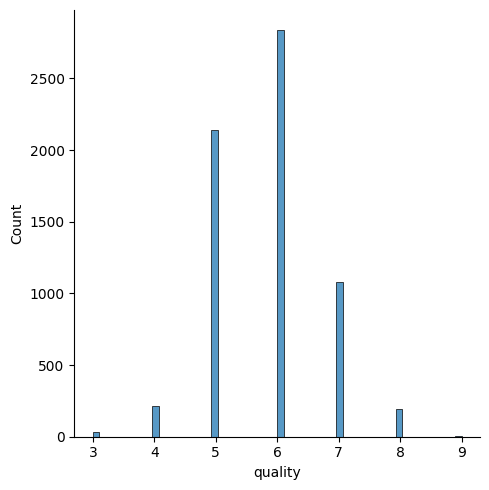

In [86]:
import seaborn as sns
sns.displot(data.quality, kde=False)

In [ ]:
## set type boolean

In [87]:
def settarget(data):
    high_quality = (data.quality >= 7).astype(int)
    data.quality = high_quality
    return data

data = settarget(data)

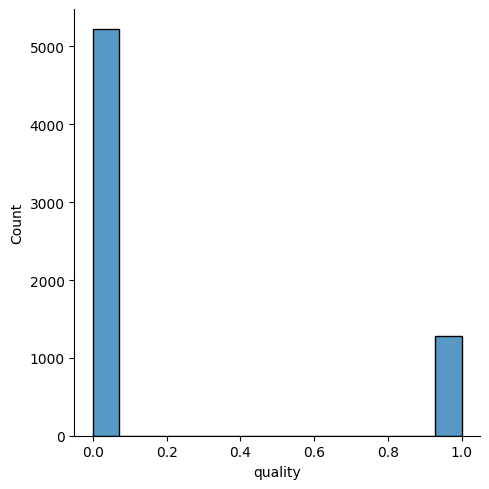

In [88]:
import seaborn as sns
sns.displot(data.quality, kde=False)

In [ ]:
## median, upper and lower quartile, IQR
## histogram for distribution

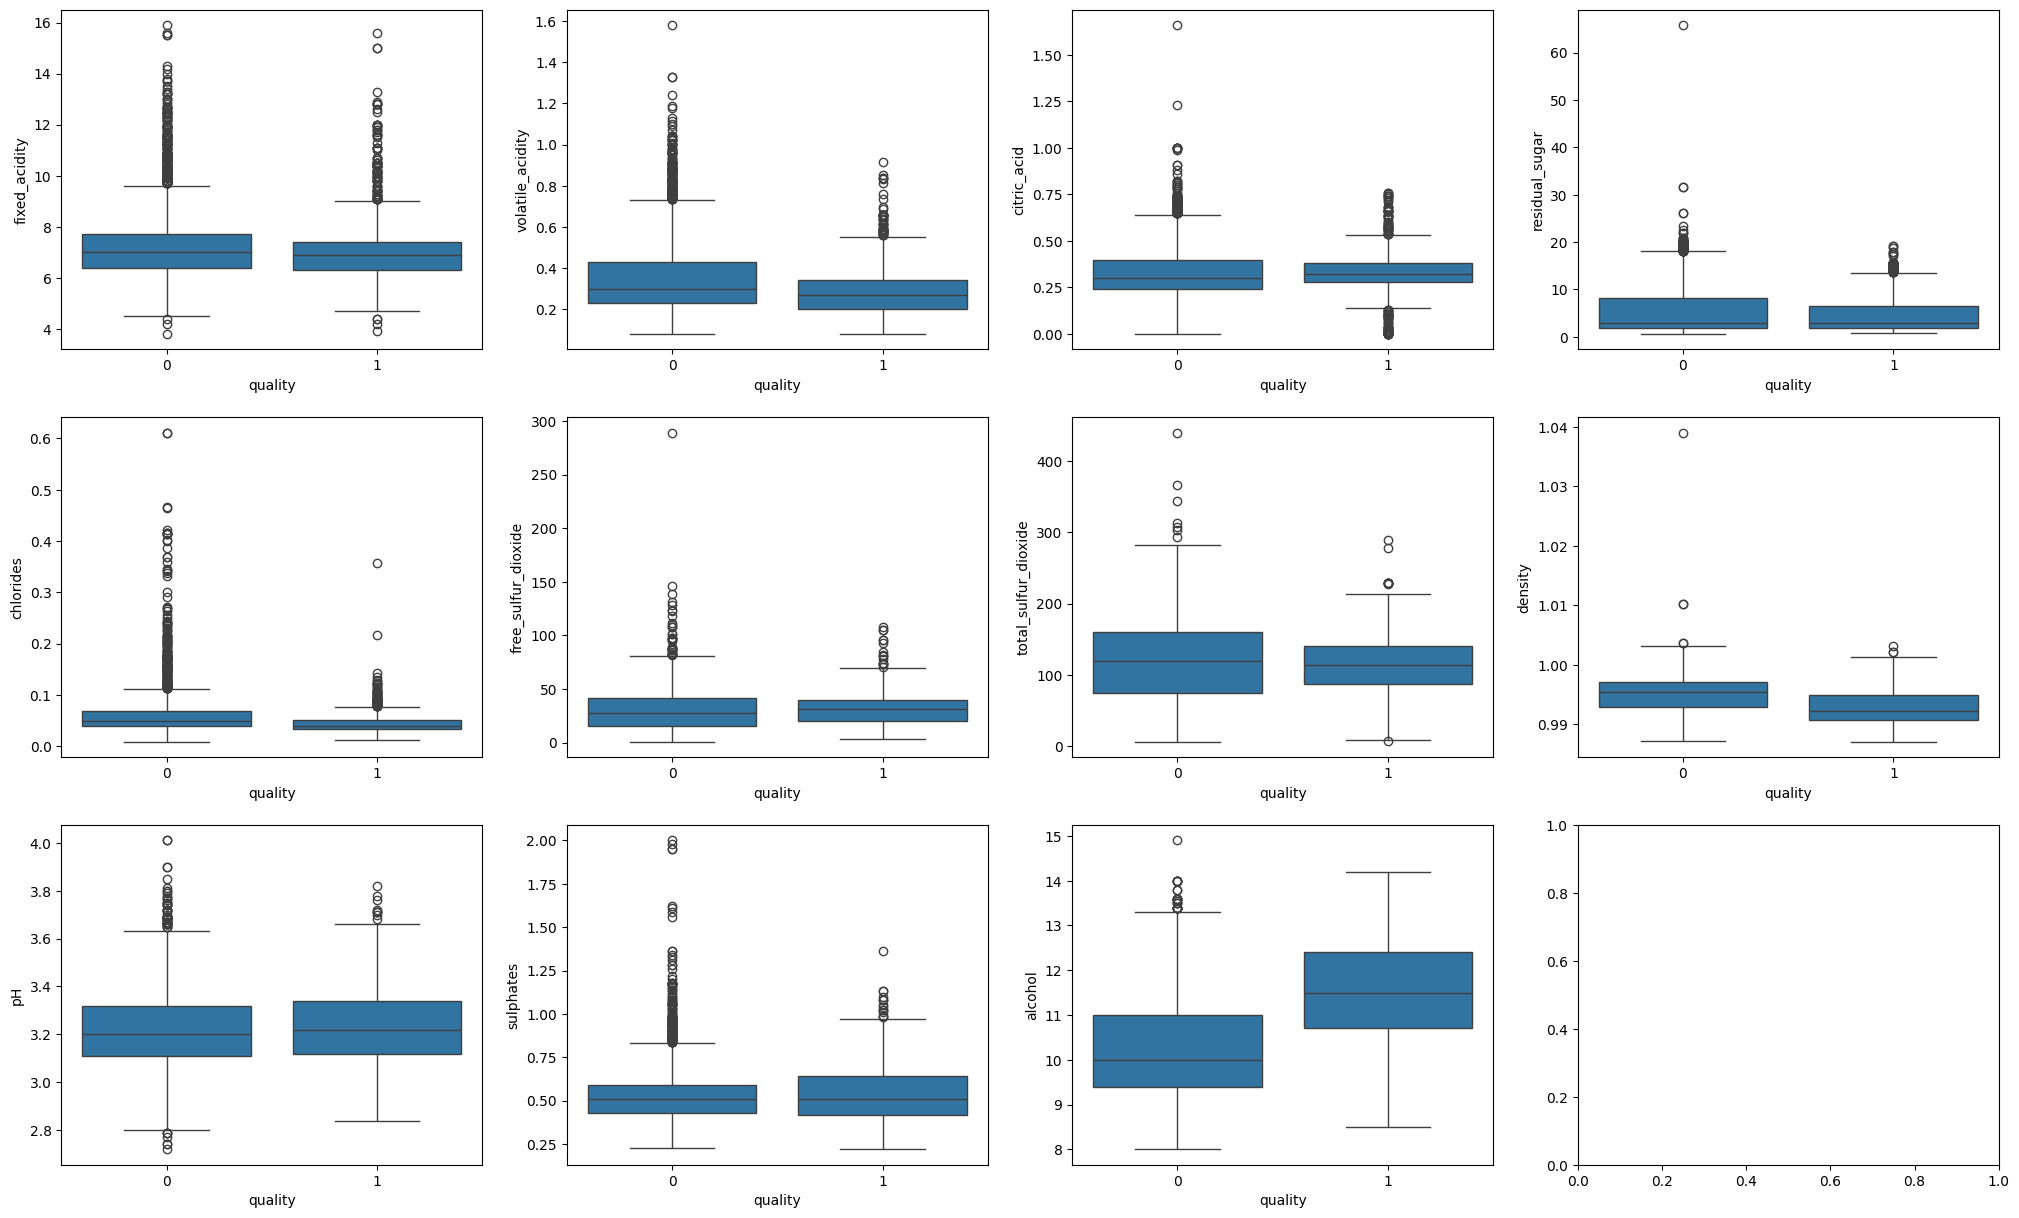

In [89]:
dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=data['quality'], y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

Check missing value

In [92]:
## scenarios for missing data - decision for the missing data
## if alcohol is not an indicator, delete that record

## what are we going to do with the outliers? are they real outliers?

In [91]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

## Prepare dataset for training model <a class="anchor" id="forth-bullet"></a>
Split the input data into 3 sets:

- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [95]:
def get_trainingdata(data):
    X = data.drop(["quality"], axis=1)
    y = data.quality

    # Split out the training data
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

    # Split the remaining data equally into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)
    return (X_train,X_val,X_test,y_train,y_val,y_test)

In [96]:
(X_train,X_val,X_test,y_train,y_val,y_test) = get_trainingdata(data)

## Build a baseline model (random forest classifier) <a class="anchor" id="fifth-bullet"></a>
Build a simple classifier using scikit-learn. Use MLflow to keep track of the model accuracy. You can read about Classification - ROC and AUC here if you want 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Enable MLflow autologging

In [20]:
experiment_name = "WineQuality"

In [21]:
# check if experiment name already exists
mlflow.set_tracking_uri("http://mlflow:5500")
mlflow.set_experiment(experiment_name)

# enable autologging
mlflow.sklearn.autolog(log_input_examples=True)

In [22]:
def log_featureimportance(model):
    tmpdir = tempfile.mkdtemp()
    filepath = os.path.join(tmpdir, 'feature_importance.json')
    feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
    feature_importances.sort_values('importance', ascending=False).to_json(filepath)
    mlflow.log_artifact(filepath)
    return

Train random forest

In [23]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

def train_randomforest(X_train,y_train,X_test,y_test):

    with mlflow.start_run(run_name='untuned_random_forest'):
        n_estimators = 10
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
        model.fit(X_train, y_train)

        predictions_test = model.predict_proba(X_test)[:,1]
        auc_score = roc_auc_score(y_test, predictions_test)
        mlflow.log_param('n_estimators', n_estimators) #specify the interested parameter/metric
        mlflow.log_metric('auc', auc_score)
        wrappedModel = SklearnModelWrapper(model)

        signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

        conda_env = _mlflow_conda_env(
            additional_conda_deps=None,
            additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
            additional_conda_channels=None,
            )
        mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)
        log_featureimportance(model)
        return model

In [24]:
model = train_randomforest(X_train,y_train,X_test,y_test)

2022/10/14 04:29:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2022/10/14 04:29:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/app-root/lib/python3.8/site-packages/_distutil

In [25]:
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])}')

AUC: 0.8540300975814177


In [26]:
# Sanity-check: This should match the feature importance logged by MLflow
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


## Experiment with a new model (xgboost) <a class="anchor" id="sixth-bullet"></a>
Use the xgboost library to train a more accurate model. Run hyperparameter tuning to train multiple models. As before, the code tracks the performance of each parameter configuration with MLflow.

In [27]:
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 50, 100, 10)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):

  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)

    booster = xgb.train(params=params, dtrain=train, num_boost_round=100,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score) #specify the interested parameter/metric

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)

    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
  )

[0]	validation-logloss:0.44333                        
[1]	validation-logloss:0.41397                        
[2]	validation-logloss:0.42087                        
[3]	validation-logloss:0.40797                        
[4]	validation-logloss:0.41671                        
[5]	validation-logloss:0.42035                        
[6]	validation-logloss:0.42613                        
[7]	validation-logloss:0.42852                        
[8]	validation-logloss:0.43271                        
[9]	validation-logloss:0.44060                        
[10]	validation-logloss:0.44639                       
[11]	validation-logloss:0.45534                       
[12]	validation-logloss:0.45760                       
[13]	validation-logloss:0.46125                       
[14]	validation-logloss:0.46433                       
[15]	validation-logloss:0.47167                       
[16]	validation-logloss:0.47850                       
[17]	validation-logloss:0.48394                       
[18]	valid

2022/10/14 04:30:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns 

[0]	validation-logloss:0.66207                                                   
[1]	validation-logloss:0.63397                                                   
[2]	validation-logloss:0.60908                                                   
[3]	validation-logloss:0.58602                                                   
[4]	validation-logloss:0.56529                                                   
[5]	validation-logloss:0.54639                                                   
[6]	validation-logloss:0.52885                                                   
[7]	validation-logloss:0.51333                                                   
[8]	validation-logloss:0.49891                                                   
[9]	validation-logloss:0.48621                                                   
[10]	validation-logloss:0.47480                                                  
[11]	validation-logloss:0.46292                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64928                                                   
[1]	validation-logloss:0.61253                                                   
[2]	validation-logloss:0.57966                                                   
[3]	validation-logloss:0.55328                                                   
[4]	validation-logloss:0.52902                                                   
[5]	validation-logloss:0.50749                                                   
[6]	validation-logloss:0.48774                                                   
[7]	validation-logloss:0.47102                                                   
[8]	validation-logloss:0.45586                                                   
[9]	validation-logloss:0.44157                                                   
[10]	validation-logloss:0.42889                                                  
[11]	validation-logloss:0.41840                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.44452                                                   
[1]	validation-logloss:0.38512                                                   
[2]	validation-logloss:0.37306                                                   
[3]	validation-logloss:0.35673                                                   
[4]	validation-logloss:0.35491                                                   
[5]	validation-logloss:0.35783                                                   
[6]	validation-logloss:0.36192                                                   
[7]	validation-logloss:0.35998                                                   
[8]	validation-logloss:0.36303                                                   
[9]	validation-logloss:0.36328                                                   
[10]	validation-logloss:0.36600                                                  
[11]	validation-logloss:0.36452                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.56695                                                   
[1]	validation-logloss:0.49378                                                   
[2]	validation-logloss:0.44155                                                   
[3]	validation-logloss:0.40086                                                   
[4]	validation-logloss:0.37521                                                   
[5]	validation-logloss:0.35622                                                   
[6]	validation-logloss:0.34453                                                   
[7]	validation-logloss:0.33476                                                   
[8]	validation-logloss:0.32688                                                   
[9]	validation-logloss:0.32048                                                   
[10]	validation-logloss:0.31849                                                  
[11]	validation-logloss:0.31509                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65860                                                   
[1]	validation-logloss:0.62888                                                   
[2]	validation-logloss:0.60210                                                   
[3]	validation-logloss:0.57870                                                   
[4]	validation-logloss:0.55768                                                   
[5]	validation-logloss:0.53812                                                   
[6]	validation-logloss:0.52052                                                   
[7]	validation-logloss:0.50554                                                   
[8]	validation-logloss:0.49123                                                   
[9]	validation-logloss:0.47832                                                   
[10]	validation-logloss:0.46684                                                  
[11]	validation-logloss:0.45579                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.42932                                                   
[1]	validation-logloss:0.39324                                                   
[2]	validation-logloss:0.40056                                                   
[3]	validation-logloss:0.41010                                                   
[4]	validation-logloss:0.40816                                                   
[5]	validation-logloss:0.41112                                                   
[6]	validation-logloss:0.42020                                                   
[7]	validation-logloss:0.42298                                                   
[8]	validation-logloss:0.42552                                                   
[9]	validation-logloss:0.42105                                                   
[10]	validation-logloss:0.42624                                                  
[11]	validation-logloss:0.43340                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61724                                                   
[1]	validation-logloss:0.56129                                                   
[2]	validation-logloss:0.51815                                                   
[3]	validation-logloss:0.48310                                                   
[4]	validation-logloss:0.45328                                                   
[5]	validation-logloss:0.42723                                                   
[6]	validation-logloss:0.40678                                                   
[7]	validation-logloss:0.39061                                                   
[8]	validation-logloss:0.37696                                                   
[9]	validation-logloss:0.36382                                                   
[10]	validation-logloss:0.35407                                                  
[11]	validation-logloss:0.34475                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65597                                                   
[1]	validation-logloss:0.62338                                                   
[2]	validation-logloss:0.59350                                                   
[3]	validation-logloss:0.56914                                                   
[4]	validation-logloss:0.54644                                                   
[5]	validation-logloss:0.52693                                                   
[6]	validation-logloss:0.50854                                                   
[7]	validation-logloss:0.49154                                                   
[8]	validation-logloss:0.47700                                                   
[9]	validation-logloss:0.46381                                                   
[10]	validation-logloss:0.45050                                                  
[11]	validation-logloss:0.43849                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65702                                                   
[1]	validation-logloss:0.62577                                                   
[2]	validation-logloss:0.59710                                                   
[3]	validation-logloss:0.57311                                                   
[4]	validation-logloss:0.55046                                                   
[5]	validation-logloss:0.53164                                                   
[6]	validation-logloss:0.51396                                                   
[7]	validation-logloss:0.49871                                                   
[8]	validation-logloss:0.48454                                                   
[9]	validation-logloss:0.47101                                                   
[10]	validation-logloss:0.45840                                                  
[11]	validation-logloss:0.44730                                                  
[12]	validation-

/opt/app-root/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



100%|██████████| 10/10 [02:17<00:00, 13.72s/trial, best loss: -0.8990124844137253]


In [28]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
best_run_id = best_run["run_id"]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.8990124844137253


In [29]:
best_run_id

'fbd116d8519d4119b32f0d7b7d56c980'

## Predict <a class="anchor" id="seventh-bullet"></a>

In [30]:
# model = mlflow.pyfunc.load_model(f"models:/TestModelD/production")
model = mlflow.pyfunc.load_model("runs:/" + best_run_id + "/model")

test_predictions = model.predict(X_test)
print(f'AUC: {roc_auc_score(y_test, test_predictions)}')

AUC: 0.903522359913793


In [31]:
from sklearn.metrics import classification_report

class_labels = ['white wine', 'red wine']
test_predictions = np.where(test_predictions>0.5, 1, 0)
print(classification_report(y_test, test_predictions, target_names=class_labels))

              precision    recall  f1-score   support

  white wine       0.90      0.95      0.92      1044
    red wine       0.73      0.57      0.64       256

    accuracy                           0.87      1300
   macro avg       0.81      0.76      0.78      1300
weighted avg       0.87      0.87      0.87      1300



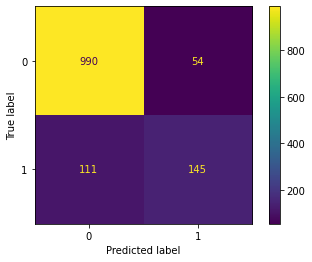

In [32]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [34]:
# register the best model
new_model_version = mlflow.register_model(f"runs:/{best_run_id}/model", "WineQuality")

Successfully registered model 'WineQuality'.
2022/10/14 04:40:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: WineQuality, version 1
Created version '1' of model 'WineQuality'.


In [ ]:
# # Promote the new model version to Production
# client.transition_model_version_stage(
#   name="TestModelD",
#   version=new_model_version.version,
#   stage="Production"
# )

In [ ]:
# # clean up models
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_registered_model(name="winequality")